This notebook is used to finish the easy fixes for the new genes after implementing all phenotypic microarrays (checkpoint 5). Below are some of the tracked genes being implemented in this notebook:

EG11557 (caiD), EG11558 (caiC), EG11559 (caiB), EG11560 (caiA), EG11561 (caiT) -- carnitine metabolism

In [1]:
import numpy as np
import ast
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
import networkx as nx
import plotly.express as px

from scipy.special import logsumexp

%matplotlib inline
# sns.set(style='dar|kgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/dev/vEcoli'))

from ecoli.processes.metabolism_redux_classic import NetworkFlowModel, FlowResult
from ecoli.library.schema import numpy_schema, bulk_name_to_idx, listener_schema, counts
from ecoli.processes.registries import topology_registry
TOPOLOGY = topology_registry.access("ecoli-metabolism-redux")
import plotly.express as px

%load_ext autoreload

In [3]:
# load checkpoint 2 model
time = '400'
date = '2025-05-15'
experiment = 'NEW_NewGenes_checkpoint2'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
bulk = pd.DataFrame(output['bulk'])
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

In [4]:
# get commonly stored variables
metabolism = agent['ecoli-metabolism-redux-classic']
stoichiometry = metabolism.stoichiometry.copy()
reaction_names = metabolism.reaction_names
fba_new_reaction_ids = metabolism.parameters["fba_new_reaction_ids"]
fba_reaction_ids_to_base_reaction_ids = metabolism.parameters['fba_reaction_ids_to_base_reaction_ids']
metabolites = metabolism.metabolite_names.copy()
binary_kinetic_idx = metabolism.binary_kinetic_idx
exchange_molecules = metabolism.exchange_molecules

S = stoichiometry .copy()
S = pd.DataFrame(S, index=metabolites , columns=reaction_names )
homeostatic_count = pd.DataFrame(fba["homeostatic_metabolite_counts"], columns=metabolism.homeostatic_metabolites).loc[24, :]
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).loc[24, :]
maintenance = pd.DataFrame(fba["maintenance_target"][1:], columns=['maintenance_reaction']).iat[24, 0]
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).loc[24, :].copy()

In [6]:
kinetic

1.1.1.39-RXN                                                                                                               15764.0
1.1.1.83-RXN                                                                                                                 698.0
1.13.11.16-RXN                                                                                                                67.0
2.1.1.79-RXN-CPD-18361/S-ADENOSYLMETHIONINE//CPD-18373/ADENOSYL-HOMO-CYS/PROTON.67.                                           90.0
2.1.1.79-RXN-CPD-18362/S-ADENOSYLMETHIONINE//CPD-18406/ADENOSYL-HOMO-CYS/PROTON.67.                                           90.0
                                                                                                                            ...   
UGD-RXN                                                                                                                       65.0
UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UNDECAPRENYL-DIPHOSPHATE/WATER//CPD-964

In [146]:
# parameters that are the same across the two simulation
kinetic_reaction_ids = metabolism.kinetic_constraint_reactions
allowed_exchange_uptake = metabolism.allowed_exchange_uptake
FREE_RXNS = ["TRANS-RXN-145", "TRANS-RXN0-545", "TRANS-RXN0-474"]
ADDED_RXNS = ['HS-TRANSPORT-RXN-CPD0-1202', 'HS-TRANSPORT-RXN-CPD0-1202 (reverse)',
                   'HS-TRANSPORT-RXN[CCO-OUTER-MEM]-OXAMATE', 'HS-TRANSPORT-RXN[CCO-OUTER-MEM]-OXAMATE (reverse)',
                   'HS-TRANSPORT-RXN[CCO-PM-BAC-NEG]-OXAMATE', 'HS-TRANSPORT-RXN[CCO-PM-BAC-NEG]-OXAMATE (reverse)',
                   'HS-BETA-GLUCURONID-RXN_CPD-3611//METOH', 'HS-SPONTANEOUS-TRANSPORT[CCO-OUTER-MEM]-HCN', 'HS-SPONTANEOUS-TRANSPORT[CCO-OUTER-MEM]-HCN (reverse)',
                   'HS-SPONTANEOUS-TRANSPORT[CCO-PM-BAC-NEG]-HCN','HS-SPONTANEOUS-TRANSPORT[CCO-PM-BAC-NEG]-HCN (reverse)']

# Functions to test NetworkFlowModel

In [147]:
def get_subset_S(S, met_of_interest):
    S_met = S.loc[met_of_interest, :]
    S_met = S_met.loc[:,~np.all(S_met == 0, axis=0)]
    return S_met, S_met.columns

def get_keys(dict, value):
    return [key for key in dict if dict[key] == value]

def test_NetworkFlowModel(objective_weights,
                          uptake_addition = set([]), uptake_removal = set([]), new_exchange_molecules = set([]),
                          add_metabolite = None, add_reaction = None, add_kinetic = None, remove_reaction = None, force_reaction = None, 
                          add_homeostatic_demand = None, solver_choice=cp.GLOP):
    # update exchanges
    uptake = metabolism.allowed_exchange_uptake.copy()
    uptake = set(uptake)
    uptake = uptake | uptake_addition
    uptake = uptake - uptake_removal
    
    exchange_molecules = metabolism.exchange_molecules.copy()
    exchange_molecules = exchange_molecules | new_exchange_molecules
    
    # update stoichiometry
    reaction_names = metabolism.reaction_names.copy()
    kinetic_reaction_ids = metabolism.kinetic_constraint_reactions.copy()
    kinetic = pd.DataFrame(fba["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).loc[24, :].copy()
    metabolites = metabolism.metabolite_names.copy()
    homeostatic_counts = homeostatic_count.copy() * metabolism.counts_to_molar.asNumber()
    
    S_new = stoichiometry.copy()
    
    if add_metabolite is not None: # add to metabolites list because they are currently not included in the model
        for m in add_metabolite:
            if m not in metabolites:
                metabolites.append(m)
        # append rows of zeros to S_new of length add_metabolite
        S_new = np.concatenate((S_new, np.zeros((len(add_metabolite), S_new.shape[1]))), axis=0)
    
    if add_reaction is not None:
        # assert add_reaction is a dictionary
        assert isinstance(add_reaction, dict)
        
        for r,s in add_reaction.items():
            if r not in reaction_names:
                reaction_names.append(r)
            # append columns of reaction stoich to S_new of length add_reaction
            new_reaction = np.zeros((S_new.shape[0], 1))
            for m, v in s.items():
                new_reaction[metabolites.index(m), 0] = v
            S_new = np.concatenate((S_new, new_reaction), axis=1)
    
    if add_kinetic is not None:
        # assert add_kinetic is a dictionary
        assert isinstance(add_kinetic, dict)
        
        for r, v in add_kinetic.items():
            if r not in kinetic_reaction_ids:
                kinetic_reaction_ids.append(r)
                kinetic[r] = v
                
    if remove_reaction is not None:
        for r in remove_reaction:
            r_idx = reaction_names.index(r)
            S_new = np.delete(S_new, r_idx, axis=1)
            reaction_names.remove(r)
            if r in kinetic_reaction_ids:
                kinetic_reaction_ids.remove(r)
                del kinetic[r]
                
    if force_reaction is not None:
        force_reaction_idx = np.array([reaction_names.index(r) for r in force_reaction])
    else:
        force_reaction_idx = force_reaction
    
    if add_homeostatic_demand is not None:
        # assert add_homeostatic_demand is a set
        assert isinstance(add_homeostatic_demand, list)

        for met in add_homeostatic_demand:
            homeostatic[met] = 100
            homeostatic_counts[met] = 1
            
    # Solve NetworkFlowModel
    model = NetworkFlowModel(
            stoich_arr=S_new,
            metabolites=metabolites,
            reactions=reaction_names,
            homeostatic_metabolites=metabolism.homeostatic_metabolites,
            kinetic_reactions=kinetic_reaction_ids,
            free_reactions=FREE_RXNS)
    model.set_up_exchanges(exchanges=exchange_molecules, uptakes=uptake)
    solution: FlowResult = model.solve(
            homeostatic_concs=homeostatic_counts, # in conc
            homeostatic_dm_targets=np.array(list(dict(homeostatic).values())), # *10^7
            maintenance_target=maintenance, # *10^6 ish
            kinetic_targets=np.array(list(dict(kinetic).values())), # *10^6 ish
            # binary_kinetic_idx=binary_kinetic_idx, #7646
            binary_kinetic_idx=None,
            force_flow_idx=force_reaction_idx,
            objective_weights=objective_weights, #same
            upper_flux_bound= 1000000000, # increase to 10^9 because notebook runs FlowResult using Counts, WC runs using conc.   
            solver=solver_choice) #SCS. ECOS, MOSEK
    return solution.objective, solution.velocities, reaction_names, S_new, metabolites, kinetic

# Create Dataframe

In [148]:
# all reactions
sim = pd.DataFrame(fba["estimated_fluxes"], columns= reaction_names).mean(axis=0).copy()

# kinetic reactions
kc_target = pd.DataFrame(fba["target_kinetic_fluxes"], columns= kinetic_reaction_ids).mean(axis=0).copy()

# Test and Implement Fixes

In [149]:
metabolism.exchange_molecules.copy()

{'3-HYDROXYPHENYL-PROPIONATE[e]',
 '3-PHENYLPROPIONATE[e]',
 'ACET[p]',
 'AMMONIUM[c]',
 'BETAINE[p]',
 'BUTANAL[c]',
 'CA+2[p]',
 'CARBON-DIOXIDE[p]',
 'CARBON-MONOXIDE[p]',
 'CH33ADO[c]',
 'CL-[p]',
 'CO+2[p]',
 'CPD-10774[p]',
 'CPD-10797[e]',
 'CPD-108[p]',
 'CPD-1772[c]',
 'CPD-239[p]',
 'CPD-534[p]',
 'CPD-560[p]',
 'CPD-564[c]',
 'CPD-674[e]',
 'CPD0-1083[e]',
 'CPD0-1202[e]',
 'CPD0-2167[c]',
 'D-ALANINE[p]',
 'D-GALACTARATE[e]',
 'D-GLUCARATE[e]',
 'D-LACTATE[p]',
 'ETOH[p]',
 'FE+2[p]',
 'FE+3[p]',
 'FORMATE[p]',
 'GLC-1-P[e]',
 'GLC[p]',
 'GLYCEROL[p]',
 'GLYCOLALDEHYDE[c]',
 'GLYCOLLATE[c]',
 'HCN[e]',
 'HYDROGEN-MOLECULE[c]',
 'HYPOXANTHINE[p]',
 'INDOLE[p]',
 'K+[p]',
 'L-SELENOCYSTEINE[c]',
 'METOH[p]',
 'MG+2[p]',
 'MI-PENTAKISPHOSPHATE[p]',
 'MN+2[p]',
 'NA+[p]',
 'NI+2[p]',
 'OXAMATE[e]',
 'OXYGEN-MOLECULE[p]',
 'PROTON[p]',
 'Pi[p]',
 'S-ADENOSYL-4-METHYLTHIO-2-OXOBUTANOATE[c]',
 'S-ALLANTOIN[e]',
 'S2O3[e]',
 'SUC[p]',
 'SULFATE[p]',
 'SUPER-OXIDE[e]',
 'TARTRATE[p]

In [141]:
objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.00001}
add_reaction={
    'TEMP-give_APO-CITRATE-LYASE': {
        'APO-CITRATE-LYASE[c]' : 1,
    },
    # 'TEMP-use_APO-CITRATE-LYASE': {
    #     'APO-CITRATE-LYASE[c]' : -1,
    #     '2-5-TRIPHOSPHORIBOSYL-3-DEPHOSPHO-[c]': -1
    # },
    'TEMP-CITRATE-LYASE-DEGREDATION': {
        'CIT[c]':-1,
        'CITRATE-LYASE[c]' : -1,
        # 'Citrate-Lyase-Citryl-Form[c]':1,
    }
}
force_reaction = ['2.7.7.61-RXN']
# force_reaction = ['TRANS-RXN-100']
# new_exchange_molecules = set(['CIT[p]'])
uptake_addition = set(['CIT[p]'])
uptake_removal = set(['GLC[p]'])
remove_reaction = ['RXN-8638-CARNITINE/ATP/WATER//CARNITINE/ADP/Pi/PROTON.45.']

In [142]:
oofv, solution_flux, test_reaction_names, S_new, test_metabolites, test_kinetic = test_NetworkFlowModel(
                                            objective_weights,
                                            # new_exchange_molecules= new_exchange_molecules,
                                            uptake_addition=uptake_addition,
                                            # add_homeostatic_demand=['CPD-19237[c]'],
                                            # uptake_removal=uptake_removal,
                                            force_reaction=force_reaction,
                                            add_reaction=add_reaction,
                                            # add_metabolite=['CH4[e]'],
                                            # remove_reaction=remove_reaction,
)
oofv

np.float64(17602.36418656097)

In [137]:
sim_flux = pd.DataFrame({
    'flux': solution_flux,
    'is_new': [
        'New Reactions' if id in fba_new_reaction_ids
        else 'TEMP' if id in add_reaction.keys()
        else 'Old Reactions'
            for id in test_reaction_names
    ]
}, index=test_reaction_names)


In [138]:
# met_of_interest = ['S-ADENOSYLMETHIONINE[c]']
met_of_interest = ['DEPHOSPHO-COA[c]', 'CITRATE-LYASE[c]', '2-5-TRIPHOSPHORIBOSYL-3-DEPHOSPHO-[c]','APO-CITRATE-LYASE[c]']
# met_of_interest = ['L-CARNITINYL-COA[c]']
S_new = pd.DataFrame(S_new, index=test_metabolites, columns=test_reaction_names)
S_met, rxns  = get_subset_S(S_new, met_of_interest)
# rxns = ['CARNDETRU-RXN', 'LCARNCOALIG-RXN','CROBETREDUCT-RXN (reverse)', 'TRANS-RXN-100', 'RXN-14074', 'TEMP-LCARNCOALIG-RXN'] #'RXN0-3601' 
rxn_flux = sim_flux.loc[rxns]
rxn_flux['kinetic'] = [test_kinetic[r] if r in kinetic_reaction_ids else False for r in rxn_flux.index]
rxn_flux

,flux,is_new,kinetic
2.3.1.49-RXN,-0.0,Old Reactions,False
2.7.7.61-RXN,100.0,New Reactions,False
2.7.8.25-RXN,100.0,New Reactions,False
CITC-RXN,100.0,Old Reactions,False
CITRATE-PRO-3S-LYASE-THIOLESTERASE-RXN,-0.0,Old Reactions,False
CITRYLY-RXN,-0.0,Old Reactions,False
CITTRANS-RXN,-0.0,Old Reactions,False
DEPHOSPHOCOAKIN-RXN,275.0,Old Reactions,False
PANTEPADENYLYLTRAN-RXN,375.0,Old Reactions,False
TEMP-give_APO-CITRATE-LYASE,100.0,TEMP,False


In [127]:
# met_of_interest = ['S-ADENOSYLMETHIONINE[c]']
met_of_interest = ['CITRATE-LYASE[c]']
# met_of_interest = ['L-CARNITINYL-COA[c]']
S_new = pd.DataFrame(S_new, index=test_metabolites, columns=test_reaction_names)
S_met, rxns  = get_subset_S(S_new, met_of_interest)
# rxns = ['CARNDETRU-RXN', 'LCARNCOALIG-RXN','CROBETREDUCT-RXN (reverse)', 'TRANS-RXN-100', 'RXN-14074', 'TEMP-LCARNCOALIG-RXN'] #'RXN0-3601'
rxn_flux = sim_flux.loc[rxns]
rxn_flux['kinetic'] = [test_kinetic[r] if r in kinetic_reaction_ids else False for r in rxn_flux.index]
rxn_flux

,flux,is_new,kinetic
2.3.1.49-RXN,-0.0,Old Reactions,False


In [ ]:
for rxn in test_reaction_names:
    if "CROBETREDUCT-RXN" in rxn:
        print(rxn)

In [81]:
#counts to conc
conc = 1.027491e+06
counts = conc * metabolism.counts_to_molar.asNumber()
counts

690058958975.9276

In [84]:
metabolism.homeostatic_concs

array([1.38000000e-01, 3.53000000e-01, 9.18000000e-02, 1.38000000e-01,
       3.04000000e-01, 5.22000000e-02, 2.18000000e-02, 1.05800000e+00,
       1.07000000e+00, 5.22500000e-03, 1.31000000e-04, 4.27000000e-03,
       4.95666667e-01, 1.75850000e-01, 3.48000000e-03, 6.63000000e-03,
       2.86666667e-01, 4.31500000e-01, 9.63000000e+00, 2.05498507e-02,
       2.58060410e+00, 1.33900000e-02, 5.90000000e-01, 7.52000000e-02,
       3.07000000e-02, 1.01832507e-01, 1.30500000e-02, 1.83500000e+00,
       2.58073288e+00, 5.74000000e-01, 1.25082274e-02, 7.37500000e-01,
       1.01834282e-01, 1.88155222e+00, 2.50000000e+00, 4.19472129e+01,
       2.79604128e+00, 1.15000000e+00, 2.07700000e+00, 1.00664423e+01,
       1.01834254e-01, 3.65436219e+00, 1.79600000e+00, 2.17000000e-02,
       1.84000000e-03, 9.47500000e-03, 1.03000000e-01, 3.78666667e-01,
       8.84000000e-03, 1.55000000e-02, 3.45000000e-02, 3.03000000e-01,
       2.82000000e-03, 5.22000000e-04, 5.07000000e-02, 1.55000000e-02,
      

In [83]:
metabolism.concentrationToCounts(metabolism.homeostatic_concs)

array([      92680,      237073,       61653,       92680,      204165,
             35057,       14641,      710549,      718608,        3509,
                88,        2868,      332888,      118100,        2337,
              4453,      192524,      289794,     6467471,       13801,
           1733124,        8993,      396242,       50504,       20618,
             68390,        8764,     1232379,     1733210,      385496,
              8400,      495302,       68392,     1263643,     1678990,
          28171585,     1877810,      772336,     1394905,     6760583,
             68391,     2454255,     1206187,       14574,        1236,
              6363,       69174,      254311,        5937,       10410,
             23170,      203494,        1894,         351,       34050,
             10410,     1306892,     1266630,       10578,       68391,
             32707,      116186,     2235733,       36065,     4280306,
            952995,      503025,     1034258,      279809,     2

In [79]:
counts(bulk.iloc[2], bulk_name_to_idx(['ABC-26-CPLX[c]'], metabolism.bulk_ids))

394    33
Name: 2, dtype: int64

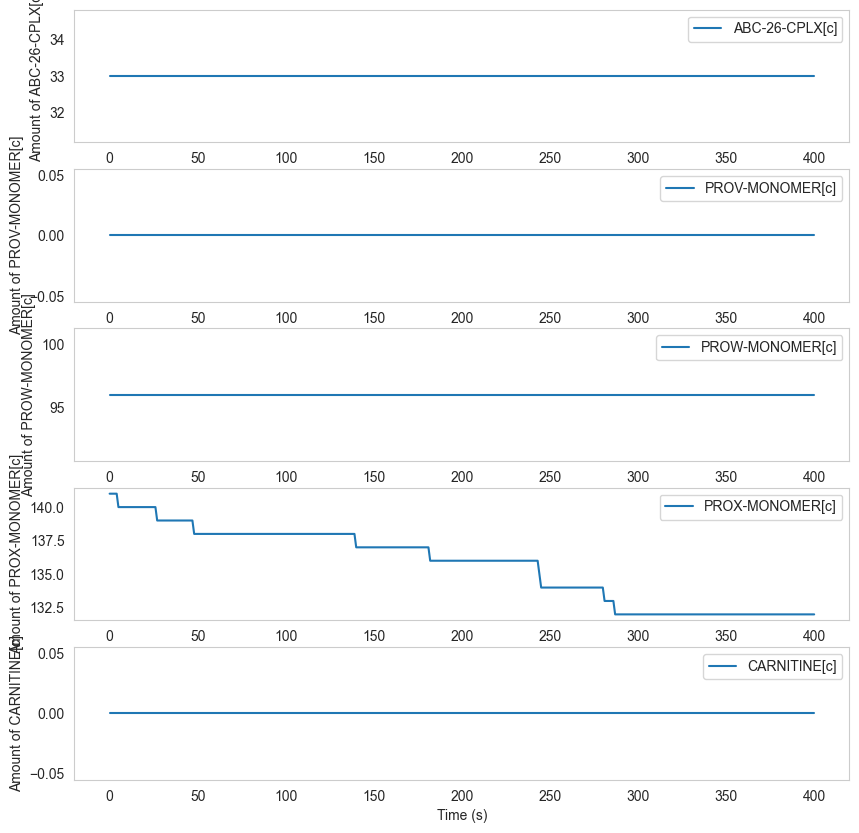

In [73]:
dem_of_interest = ['ABC-26-CPLX[c]', 'PROV-MONOMER[c]', 'PROW-MONOMER[c]', 'PROX-MONOMER[c]']
dem_of_interest_bulk_idx = bulk_name_to_idx(dem_of_interest, metabolism.bulk_ids)
%matplotlib inline
n = len(dem_of_interest)
plt.figure(figsize=(10, 2*n))
for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.plot(bulk[dem_of_interest_bulk_idx[i]], label=dem_of_interest[i])
    plt.xlabel('Time (s)')
    plt.ylabel("Amount of " + str(dem_of_interest[i]))
    plt.legend()
    plt.grid()


In [ ]:
S_temp = S.loc[:,rxns]
S_temp = S_temp[S_temp.sum(axis=1) != 0]
S_temp

In [ ]:
%store -r df_all_gene_usage df_all_gene_usage_cp1 df_all_gene_usage_cp2 df_all_gene_usage_cp3_GLOP df_all_gene_usage_cp4_w_cp23

In [ ]:
df_all_gene_usage_cp1.head()

In [ ]:
df_all_gene_usage_cp1.loc[['G6286']]

In [ ]:
df_all.loc[ADDED_RXNS]